In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

import warnings; warnings.simplefilter('ignore')
from time import time
import numpy as np
from scipy.io import arff
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score
from keras.optimizers import SGD, Adam, Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.layers import Dropout, Input, Dense,Lambda, BatchNormalization
from sklearn.utils import shuffle
from keras.models import Model,Sequential, load_model
from keras import backend as K


1 Physical GPUs, 1 Logical GPUs


Using TensorFlow backend.


In [2]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def rmse(y_true, y_pred):
    return K.exp(K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)))

def coeff_determination_simple(y_true, y_pred):
    SS_res =  np.sum(np.square( y_true - y_pred )) 
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


In [3]:
# def plot_history(history, title=''):
#     plot_r2 = {'coeff_determination': history.history['coeff_determination'], 'val_coeff_determination': history.history['val_coeff_determination']}
#     plot_rmse = {'rmse': history.history['rmse'], 'val_rmse': history.history['val_rmse']}
#     plot_mse = {'mean_squared_error': history.history['mean_squared_error'], 'val_mean_squared_error': history.history['val_mean_squared_error']}
#     plot_mae = {'mean_absolute_error': history.history['mean_absolute_error'], 'val_mean_absolute_error': history.history['val_mean_absolute_error']}
#     plot_loss = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}

#     _ = pd.DataFrame(plot_r2).plot(figsize=(15, 5), title='{0} (Epoch v/s R2)'.format(title))
#     _.set_xlabel("Epoch")
#     _.set_ylabel("R2")
   
#     _ = pd.DataFrame(plot_rmse).plot(figsize=(15, 5), title='{0} (Epoch v/s RMSE)'.format(title))
#     _.set_xlabel("Epoch")
#     _.set_ylabel("RMSE")
    
#     _ = pd.DataFrame(plot_mse).plot(figsize=(15, 5), title='{0} (Epoch v/s MSE)'.format(title))
#     _.set_xlabel("Epoch")
#     _.set_ylabel("MSE")
    
#     _ = pd.DataFrame(plot_mae).plot(figsize=(15, 5), title='{0} (Epoch v/s MAE)'.format(title))
#     _.set_xlabel("Epoch")
#     _.set_ylabel("MAE")

#     _ = pd.DataFrame(plot_loss).plot(figsize=(15, 5), title='{0} (Epoch v/s Loss)'.format(title))
#     _.set_xlabel("Epoch")
#     _.set_ylabel("Loss")

In [53]:
# sv, mse_svr_curr,mse_svr_val_curr,mse_svr_test_curr,scores_train_curr,scores_val_curr, scores_test_curr = train_svr_legacydata()

before train: Init time: 1583860488.59
after train, finish time: 1583860718.347
training time {} 229.757
MSE val: 534.5980007027844, MSE train 1279.9678402801212, R2 val:0.9409941381602975, R2 train:0.7355802127375316
MSE test: 263.38325810096956, R2 test:0.9851237894253988


In [3]:
###################### New MEthods ##########
def load_csv_data(url, drop_columns=[]):
    
    #READ data
    print("Loading data")
    df = pd.read_csv(url)
    print("Removing columns",drop_columns)
    df = df.drop(columns=drop_columns)
    return df

def scale_log_data_targets(df_train, df_val, df_test):
    
    df_train = shuffle(df_train)
    df_train.reset_index(inplace=True, drop=True) 

    df_val = shuffle(df_val)
    df_val.reset_index(inplace=True, drop=True)

    df_test = shuffle(df_test)
    df_test.reset_index(inplace=True, drop=True)
    
    df_row = pd.concat([df_train,df_val, df_test])
    x_train, x_temp, y_train, y_temp = train_test_split(df_row[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']], df_row['time'], test_size=0.40, random_state=42)
    
    x_val, x_temp, y_v, y_temp = train_test_split(x_temp,df_row, test_size=0.50, random_state=42)
    y_train = df_train['time'].values.reshape(-1, 1)
    y_val   = df_val['time'].values.reshape(-1, 1)
    y_test  = df_test['time'].values.reshape(-1, 1)
    
#     x_train = df_train[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
#        'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
#        'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
#        'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
#        'pcs22', 'pcs23', 'pcs24']]
#     x_val = df_val[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
#        'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
#        'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
#        'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
#        'pcs22', 'pcs23', 'pcs24']]
#     x_test = df_test[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
#        'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
#        'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
#        'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
#        'pcs22', 'pcs23', 'pcs24']]

    y_val_log = np.log(y_val)
    y_train_log = np.log(y_train)
    y_test_log = np.log(y_test)

    y_train_log_min = np.min(y_train_log)
    y_train_min = np.min(y_train)

    y_train_log_max = np.max(y_train_log)
    y_train_max = np.max(y_train)

    print("targets min:{} max: {}".format(y_train_min, y_train_max))
    print("targets in log scale min:{} max: {}".format(y_train_log_min, y_train_log_max))
    return x_train, x_val, x_test , y_train, y_val, y_test, y_train_log, y_val_log, y_test_log

def normalize_target(y_train_log, y_val_log, y_test_log):
    """
    Normalize data using StandardScaler.
    
    return scaler object; values of train,val and test sets standarized. 
    """
    #Standarización del target
    scaler = StandardScaler()
    y_train_log_std = scaler.fit_transform(y_train_log)
    y_val_log_std = scaler.transform(y_val_log)
    y_test_log_std = scaler.transform(y_test_log)
    return scaler, y_train_log_std, y_val_log_std, y_test_log_std


def train_autoencoder(x_train, x_val, encoding_dim, verbose,batch_size=120):
    """
    Train an autoencoder for preprocessing data.
    """
    # Set callback functions to early stop training and save the best model so far
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=10),
                ]
    # this is the size of our encoded representations
    # this is our input placeholder
    input_img = Input(shape=(x_train.shape[1],))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x_train.shape[1], activation='linear')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))

    autoencoder.compile(optimizer=Nadam(learning_rate=0.0001), loss='mse')
    print("Autoencoder Summary")
    print(autoencoder.summary())
    autoencoder.fit(x_train, x_train,
                    epochs=300,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_val, x_val),
                    verbose=verbose,
                    callbacks=callbacks_best)
    
    plot_history(autoencoder.history, metrics_list=['loss','val_loss'], start_at_epoch=10)
    autoencoder.save("models_newdata/autoencoder_newdata.hdf5")

    return autoencoder
# Set callback functions to early stop training and save the best model so far
def build_train_ann(x_train, y_train, x_val, y_val, n1, n2, n3, epochs, optimizer, dropout, verbose=False):
    
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=20),
                      ModelCheckpoint(filepath='models_newdata/bestm_newdata.h5'.format(n1,n2,n3),
                                      monitor='val_loss', save_best_only=True
                                     )]

    model = Sequential()
    model.add(Dense(n1, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n3, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', coeff_determination, rmse])
    t0=time()
    print("before train: Init time: {}".format(round(t0,3)))
    history = model.fit(x_train.values, y_train,
                    epochs=epochs,
                    batch_size=120,
                    validation_data=(x_val.values, y_val),
                    callbacks=callbacks_best,
                    verbose=verbose
                     )
    t1=time()
    print("after train, finish time: {}".format(round(t1,3)))
    print("training time {}",format(round(t1-t0, 3)))
    print(model.summary())

    return model, history, round(t1-t0, 3)


# Set callback functions to early stop training and save the best model so far
def build_train_ann_with_aec(autoencoder, x_train, y_train, x_val, y_val, n1, n2, n3, epochs, optimizer, dropout,verbose=False):
    
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=20),
                      ModelCheckpoint(filepath='models_newdata/bestm_newdata.h5'.format(n1,n2,n3),
                                      monitor='val_loss', save_best_only=True
                                     )]

    model = Sequential()
    model.add(autoencoder.layers[0])
    model.add(autoencoder.layers[1])
    model.add(Dense(n1, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n3, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', coeff_determination, rmse])
    t0=time()
    print("before train: Init time: {}".format(round(t0,3)))
    history = model.fit(x_train.values, y_train,
                    epochs=epochs,
                    batch_size=120,
                    validation_data=(x_val.values, y_val),
                    callbacks=callbacks_best,
                    verbose=verbose
                     )
    t1=time()
    print("after train, finish time: {}".format(round(t1,3)))
    print("training time {}",format(round(t1-t0, 3)))
    print(model.summary())

    return model, history, round(t1-t0, 3)


def get_metrics(model, scaler, x_data, y_true_data, label_set="Data"):
    y_pred = np.exp(scaler.inverse_transform(model.predict(x_data).reshape(-1, 1)))
    rmse = np.sqrt(mean_squared_error(y_true_data, y_pred))
    r2 = r2_score(y_true_data, y_pred)
    print("RMSE "+label_set, rmse)
    print("R2 SCORE "+label_set, r2)
    return rmse, r2

def plot_history(history, metrics_list, start_at_epoch=0):
    for metric in metrics_list:
        plt.plot(history.history[metric][start_at_epoch:],label=metric)
    plt.legend()
    plt.title("Metrics by epochs(Start from epoch:{})".format(start_at_epoch))
    plt.show()

def build_train_svr(x_train, y_train, C=300,nu=0.3):
    sv = NuSVR(C=C, nu=nu)
    t0=time()
    print("before train: Init time: {}".format(round(t0,3)))

    sv.fit(x_train, np.ravel(y_train))
    t1=time()
    print("after train, finish time: {}".format(round(t1,3)))
    print("training time {}",format(round(t1-t0,3)))
    
    return sv

def train_svr_legacydata(C=300,nu=0.3):
    from sklearn.svm import NuSVR
    from sklearn.preprocessing import StandardScaler
    from time import time
    

    #load legacy data
    df        = loadarff_data('/home/dcasals/jupyter/mlproject/dataold/x_features.arff', drop_columns=drop_columns)
    data_val  = loadarff_data('/home/dcasals/jupyter/mlproject/dataold/xval_features.arff', drop_columns=drop_columns)
    data_test = loadarff_data('/home/dcasals/jupyter/mlproject/dataold/xtest_features.arff', drop_columns=drop_columns)
    
    #print columns
    print("Columns datasets", df.columns)
    #transform data and get in log scale
    x_train, x_val, x_test , y_train, y_val, y_test, y_train_log, y_val_log, y_test_log = scale_log_data_targets(df, data_val, data_test)
    print("Shape datasets x: {}".format(x_train.shape))
    print("Shape datasets xval: {}".format(x_val.shape))
    print("Shape datasets xtest: {}".format(x_test.shape))

    # scale target using StandarSacaler
    scalery, y_train_log_std, y_val_log_std, y_test_log_std = normalize_target(y_train_log, y_val_log, y_test_log)
    
    print(
    "Dimensiones de los datos: Cant ejemplos en train:{}, Val: {} Test: {}".
      format(x_train.shape[0], x_val.shape[0], x_test.shape[0])
     )
    
    ################
    svr_model = build_train_svr(x_train, y_train, C=300,nu=0.3)
    y_train_hat_svr = scaler_yz.inverse_transform(sv.predict(x_train).reshape(-1, 1))
    y_val_hat_svr = scaler_yz.inverse_transform(sv.predict(x_val).reshape(-1, 1))
    y_test_hat_svr = scaler_yz.inverse_transform(sv.predict(x_test).reshape(-1, 1))

    rmse_train, r2_train = get_metrics(y_test_hat_svr, scalery, x_train, y_train, label_set=" Train ")
    rmse_val, r2_val     = get_metrics(y_test_hat_svr, scalery, x_val, y_val, label_set=" Val ")
    rmse_test, r2_test   = get_metrics(y_test_hat_svr, scalery, x_test, y_test, label_set=" Test ")

    print("MSE val: {}, MSE train {}, R2 val:{}, R2 train:{}".format(mse_svr_val_curr,mse_svr_curr,scores_val_curr,scores_train_curr))
    print("MSE test: {}, R2 test:{}".format(mse_svr_test_curr, scores_test_curr))
    return svr_model, scalery, rmse_train, rmse_val, rmse_test, r2_train, r2_val, r2_test

def train_complete_model(with_aec=True, verbose_train=False,drop_columns=[], units=[85, 60, 60], optimizer=None, train_aec=True):
    #load legacy data
    df_train  = load_csv_data("/home/dcasals/jupyter/mlproject/xtrain_std.csv", drop_columns=drop_columns)
    data_val  = load_csv_data("/home/dcasals/jupyter/mlproject/xval_std.csv", drop_columns=drop_columns)
    data_test = load_csv_data("/home/dcasals/jupyter/mlproject/xtest_std.csv", drop_columns=drop_columns)
    
    #print columns
    print("Columns datasets", df_train.columns)
    #transform data and get in log scale
    x_train, x_val, x_test , y_train, y_val, y_test, y_train_log, y_val_log, y_test_log = scale_log_data_targets(df_train, data_val, data_test)
    print("Shape datasets x: {}".format(x_train.shape))
    print("Shape datasets xval: {}".format(x_val.shape))
    print("Shape datasets xtest: {}".format(x_test.shape))

    # scale target using StandarSacaler
    scalery, y_train_log_std, y_val_log_std, y_test_log_std = normalize_target(y_train_log, y_val_log, y_test_log)
    
    print(
    "Dimensiones de los datos: Cant ejemplos en train:{}, Val: {} Test: {}".
      format(x_train.shape[0], x_val.shape[0], x_test.shape[0])
     )
    #Train autoencoder:
    if train_aec:
        autoencoder = train_autoencoder(x_train, x_val, 20, verbose=False)
    else:
        autoencoder = load_model("models_newdata/autoencoder_newdata.hdf5")
    #Train model ANN
    epochs=450
    dropout=0.25
    if optimizer is None:
        optimizer=Adam(learning_rate=0.00015)
    if with_aec:
        
        model, history, time_training = build_train_ann_with_aec(
            autoencoder,
            x_train,
            y_train_log_std,
            x_val,
            y_val_log_std,
            units[0], 
            units[1], 
            units[2],
            epochs,
            optimizer,
            dropout,
            verbose=verbose_train)
    else:
        model, history, time_training = build_train_ann(
            x_train,
            y_train_log_std,
            x_val,
            y_val_log_std,
            units[0], 
            units[1], 
            units[2],
            epochs,
            optimizer,
            dropout,
            verbose=verbose_train)
    #load weights for best model.
#     best_model = build_best_model(units=[85, 60, 60])
#     best_model.load_weights('models_legacy/bestm_legacydata.hdf5')
    rmse_train, r2_train = get_metrics(model, scalery, x_train, y_train, label_set=" Train ")
    rmse_val, r2_val     = get_metrics(model, scalery, x_val, y_val, label_set=" Val ")
    rmse_test, r2_test   = get_metrics(model, scalery, x_test, y_test, label_set=" Test ")
    plot_history(history, metrics_list=['loss','val_loss'],start_at_epoch=5)
    return model, scalery, rmse_train, rmse_val, rmse_test, r2_train, r2_val, r2_test, time_training

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584059714.019
after train, finish time: 1584060011.835
training time {} 297.816
Model: "sequential_10"
________________________________________________________________

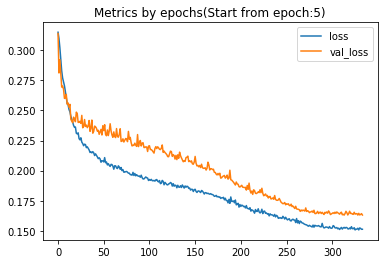

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584060013.696
after train, finish time: 1584060048.059
training time {} 34.363
Model: "sequential_11"
_________________________________________________________________

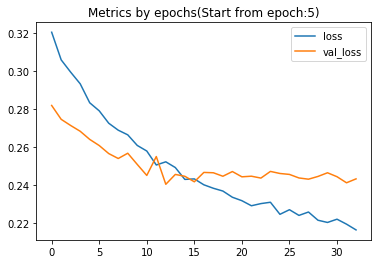

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584060049.957
after train, finish time: 1584060349.303
training time {} 299.346
Model: "sequential_12"
________________________________________________________________

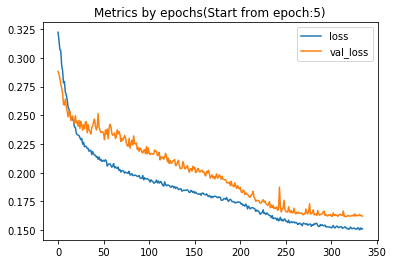

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584060351.89
after train, finish time: 1584060696.029
training time {} 344.139
Model: "sequential_13"
_________________________________________________________________

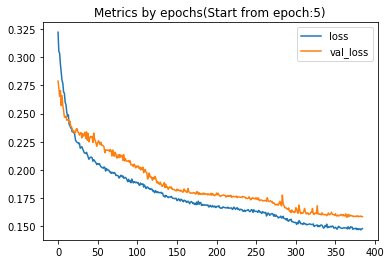

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584060697.936
after train, finish time: 1584061090.563
training time {} 392.627
Model: "sequential_14"
________________________________________________________________

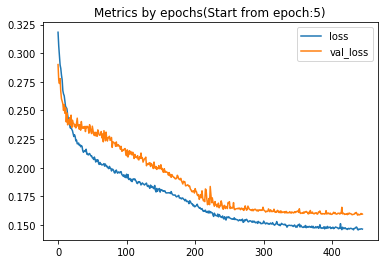

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584061092.46
after train, finish time: 1584061465.012
training time {} 372.551
Model: "sequential_15"
_________________________________________________________________

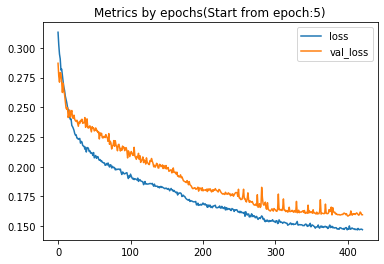

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584061466.883
after train, finish time: 1584061743.473
training time {} 276.59
Model: "sequential_16"
_________________________________________________________________

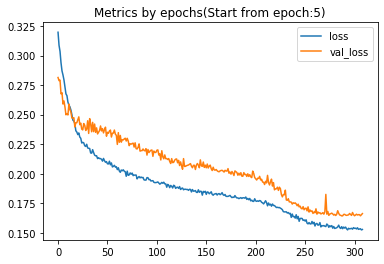

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584061745.423
after train, finish time: 1584062049.914
training time {} 304.491
Model: "sequential_17"
________________________________________________________________

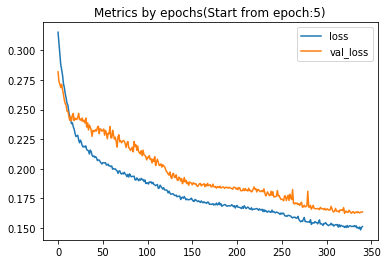

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584062051.805
after train, finish time: 1584062371.149
training time {} 319.345
Model: "sequential_18"
________________________________________________________________

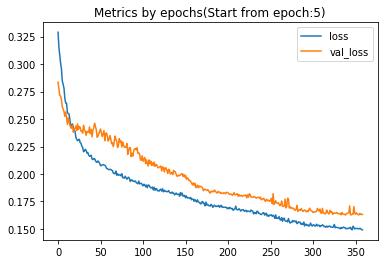

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584062373.77
after train, finish time: 1584062647.545
training time {} 273.775
Model: "sequential_19"
_________________________________________________________________

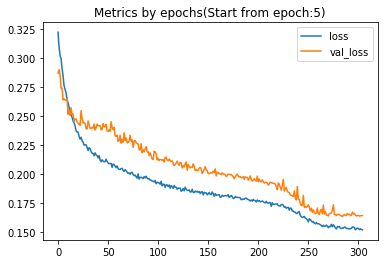

RMSE mean 10 rams: 495.8655046636245
Best RMSE: 465.0006409163959
R2 mean 10 rams: 0.5583905521982813


In [37]:
values_rmse = []
values_r2 = []
best_rmse = 100000.0

for i in range(0,10):
    optimizer=Adam(learning_rate=0.00015)
    model, scalery, rmse_train, rmse_val, rmse_test, r2_train, r2_val, r2_test, time_training = train_complete_model(verbose_train=False, optimizer=optimizer, drop_columns=[],units=[260, 300, 240],train_aec=False)
    values_rmse.append(rmse_test)
    values_r2.append(r2_test)
    if (rmse_test < best_rmse):
        best_model = model
        best_rmse = rmse_test
print("RMSE mean 10 rams: {}".format(np.mean(values_rmse)))
print("Best RMSE: {}".format(best_rmse))
print("R2 mean 10 rams: {}".format(np.mean(values_r2)))

<!-- <span style="color:blue">
     -->
### Best Configuration
<!-- - Optimizer: SGD with learning rate 0.001.
- 3 layers with [85, 80, 60] units.
- first layer: initialization random uniform.
- we execute 10 runs and calculate the mean for result reports.
</span> -->

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584066603.695
after train, finish time: 1584066915.795
training time {} 312.101
Model: "sequential_20"
________________________________________________________________

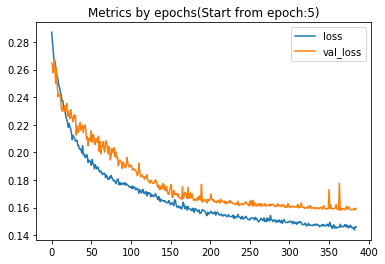

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584066917.581
after train, finish time: 1584067136.533
training time {} 218.953
Model: "sequential_21"
________________________________________________________________

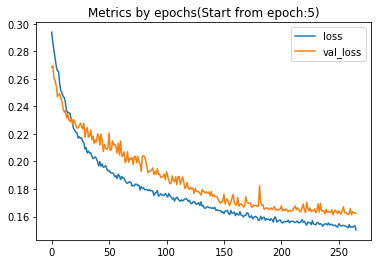

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584067138.278
after train, finish time: 1584067395.111
training time {} 256.833
Model: "sequential_22"
________________________________________________________________

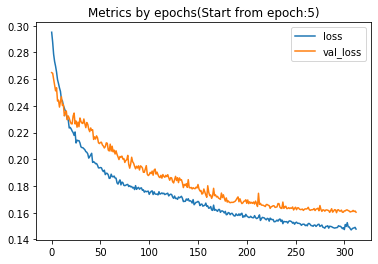

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584067396.893
after train, finish time: 1584067559.243
training time {} 162.35
Model: "sequential_23"
_________________________________________________________________

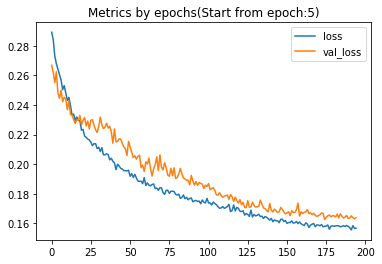

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584067560.95
after train, finish time: 1584067742.028
training time {} 181.078
Model: "sequential_24"
_________________________________________________________________

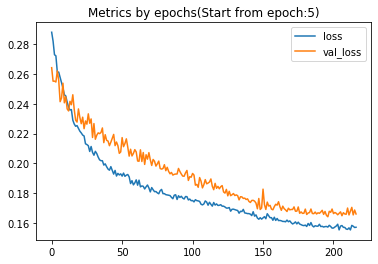

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584067743.826
after train, finish time: 1584067908.574
training time {} 164.748
Model: "sequential_25"
________________________________________________________________

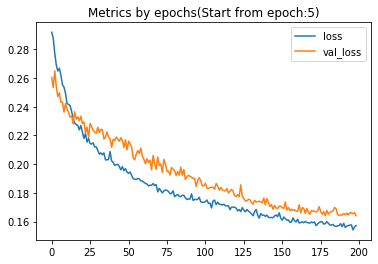

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584067910.4
after train, finish time: 1584068119.885
training time {} 209.484
Model: "sequential_26"
_________________________________________________________________


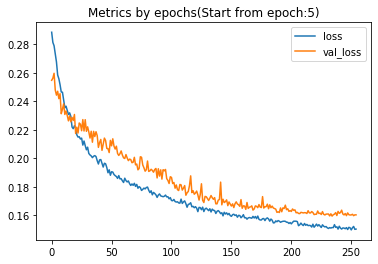

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584068121.594
after train, finish time: 1584068325.821
training time {} 204.227
Model: "sequential_27"
________________________________________________________________

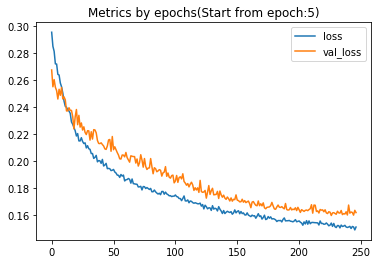

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584068327.536
after train, finish time: 1584068501.774
training time {} 174.238
Model: "sequential_28"
________________________________________________________________

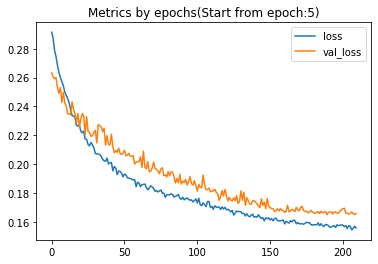

Loading data
Removing columns []
Loading data
Removing columns []
Loading data
Removing columns []
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'time'],
      dtype='object')
targets min:1 max: 14766
targets in log scale min:0.0 max: 9.60008251961911
Shape datasets x: (9947, 34)
Shape datasets xval: (4264, 34)
Shape datasets xtest: (4737, 34)
Dimensiones de los datos: Cant ejemplos en train:9947, Val: 4264 Test: 4737
before train: Init time: 1584068503.585
after train, finish time: 1584068702.993
training time {} 199.408
Model: "sequential_29"
________________________________________________________________

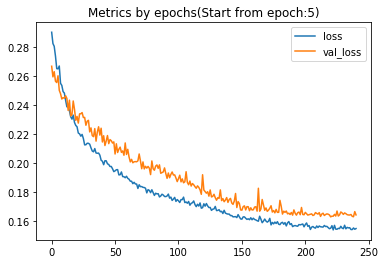

RMSE mean 10 rams: 495.46253692604625
Best RMSE: 472.54372920861863
R2 mean 10 rams: 0.563653510704315


In [42]:
values_rmse = []
values_r2 = []
best_rmse = 100000.0

for i in range(0,10):
    optimizer=Adam(learning_rate=0.00015)
    model, scalery, rmse_train, rmse_val, rmse_test, r2_train, r2_val, r2_test, time_training = train_complete_model(with_aec=False, verbose_train=False, optimizer=optimizer, drop_columns=[],units=[260, 300, 240],train_aec=False)
    values_rmse.append(rmse_test)
    values_r2.append(r2_test)
    if (rmse_test < best_rmse):
        best_model = model
        best_rmse = rmse_test
print("RMSE mean 10 rams: {}".format(np.mean(values_rmse)))
print("Best RMSE: {}".format(best_rmse))
print("R2 mean 10 rams: {}".format(np.mean(values_r2)))